In [ ]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [ ]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
#
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
#
# pip install

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge, Lars, RANSACRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer

### Область работы 2 (поиск  модели .... )

In [23]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 

path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

In [2]:
def mse_irq(y_true, y_pred):
    delta = y_pred - y_true
    q_25 = np.quantile(delta, 0.25)
    q_75 = np.quantile(delta, 0.75)
    irq = q_75 - q_25
    mask = (delta < q_25 - 1.5*irq) | (delta > q_75 + 1.5*irq)
    if delta[mask].sum() == 0:
        results = 0
    else:
        results = -np.sum((delta[mask])**2)/len(delta[mask])
    return results

In [25]:
df = pd.read_csv(path_train)
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.55,Ideal,I,SI1,61.7,55.0,1134,5.29,5.31,3.27
1,0.94,Premium,E,SI1,62.4,56.0,4580,6.27,6.24,3.90
2,0.33,Premium,E,SI2,60.0,59.0,594,4.49,4.47,2.69
3,0.31,Ideal,D,VS2,59.4,56.0,879,4.45,4.40,2.63
4,2.01,Very Good,H,SI1,62.8,59.0,17759,7.99,8.04,5.03
...,...,...,...,...,...,...,...,...,...,...
40450,1.50,Very Good,D,SI1,60.7,62.0,11442,7.30,7.33,4.44
40451,1.51,Ideal,D,SI1,61.9,57.0,11834,7.35,7.42,4.57
40452,0.42,Ideal,G,SI2,60.9,56.0,971,4.87,4.89,2.97
40453,2.05,Premium,E,SI2,59.7,59.0,17237,8.39,8.27,4.97


In [4]:
df.describe()

,carat,depth,table,price,x,y,z
count,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.000000,40455.00000
mean,0.797227,61.746219,57.451551,3938.457274,5.728667,5.732720,3.53753
std,0.474440,1.420742,2.230915,3998.851904,1.123597,1.153284,0.70956
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.00000
25%,0.400000,61.000000,56.000000,945.000000,4.710000,4.720000,2.91000
50%,0.700000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.53000
75%,1.040000,62.500000,59.000000,5324.500000,6.540000,6.530000,4.03000
max,5.010000,78.200000,95.000000,18818.000000,10.740000,58.900000,31.80000


In [5]:
df.describe(include=object)

,cut,color,clarity
count,40455,40455,40455
unique,5,7,8
top,Ideal,G,SI1
freq,16260,8439,9795


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   price    40455 non-null  int64  
 7   x        40455 non-null  float64
 8   y        40455 non-null  float64
 9   z        40455 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [7]:
duplicate = df[df.duplicated()]
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40377 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40377 non-null  float64
 1   cut      40377 non-null  object 
 2   color    40377 non-null  object 
 3   clarity  40377 non-null  object 
 4   depth    40377 non-null  float64
 5   table    40377 non-null  float64
 6   price    40377 non-null  int64  
 7   x        40377 non-null  float64
 8   y        40377 non-null  float64
 9   z        40377 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


['SI1', 'VS2', 'SI2', 'VS1', 'VVS2', 'VVS1', 'IF', 'I1']
[9777, 9182, 6819, 6133, 3817, 2734, 1358, 557]


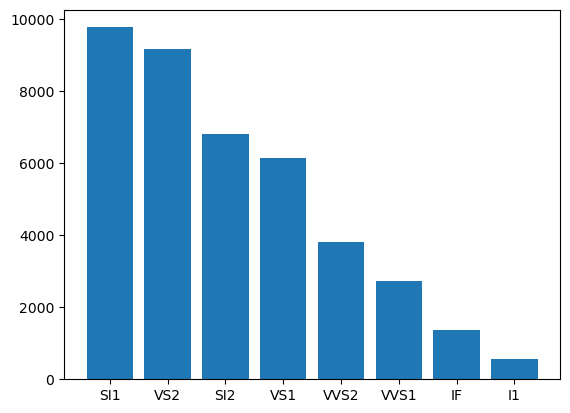

In [8]:
clarityindexes = df["clarity"].value_counts().index.tolist()
claritycount = df["clarity"].value_counts().values.tolist()

print(clarityindexes)
print(claritycount)
plt.bar(clarityindexes, claritycount)
plt.show()

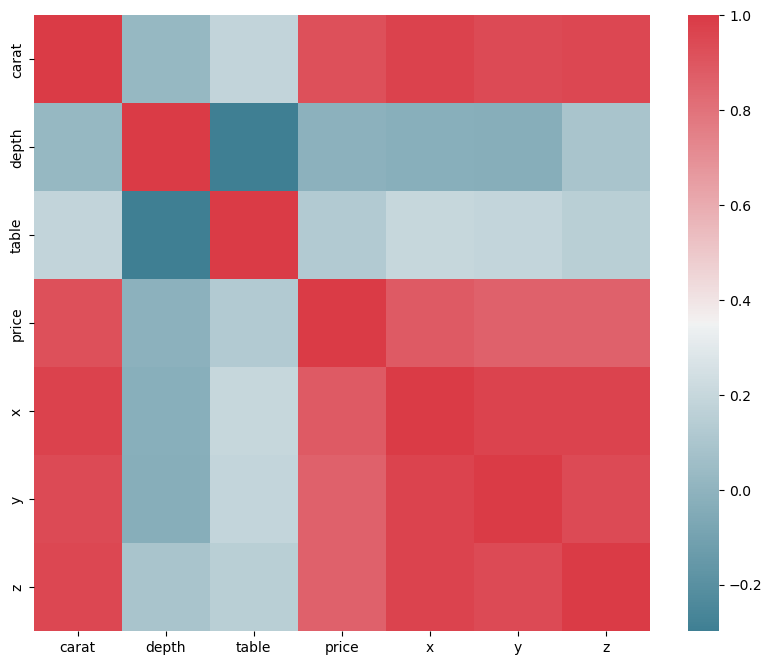

In [9]:
df_1 = df.drop(['cut', 'color', 'clarity'], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
corr = df_1.corr()
sns.heatmap(corr, mask=np.zeros_like(corr),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
plt.show()

In [10]:
df.loc[:, 'y'] = np.where(df['y'] >= 15, df['y'] / 10, df['y'])
df.loc[:, 'z'] = np.where(df['z'] >= 15, df['z'] / 10, df['z'])
df.describe()

,carat,depth,table,price,x,y,z
count,40377.00000,40377.000000,40377.000000,40377.000000,40377.000000,40377.000000,40377.000000
mean,0.79713,61.745600,57.452126,3938.759690,5.728777,5.730864,3.536874
std,0.47404,1.420043,2.231121,3998.041468,1.122689,1.114259,0.694939
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,946.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.690000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.000000,6.540000,6.530000,4.030000
max,5.01000,78.200000,95.000000,18818.000000,10.740000,10.540000,8.060000


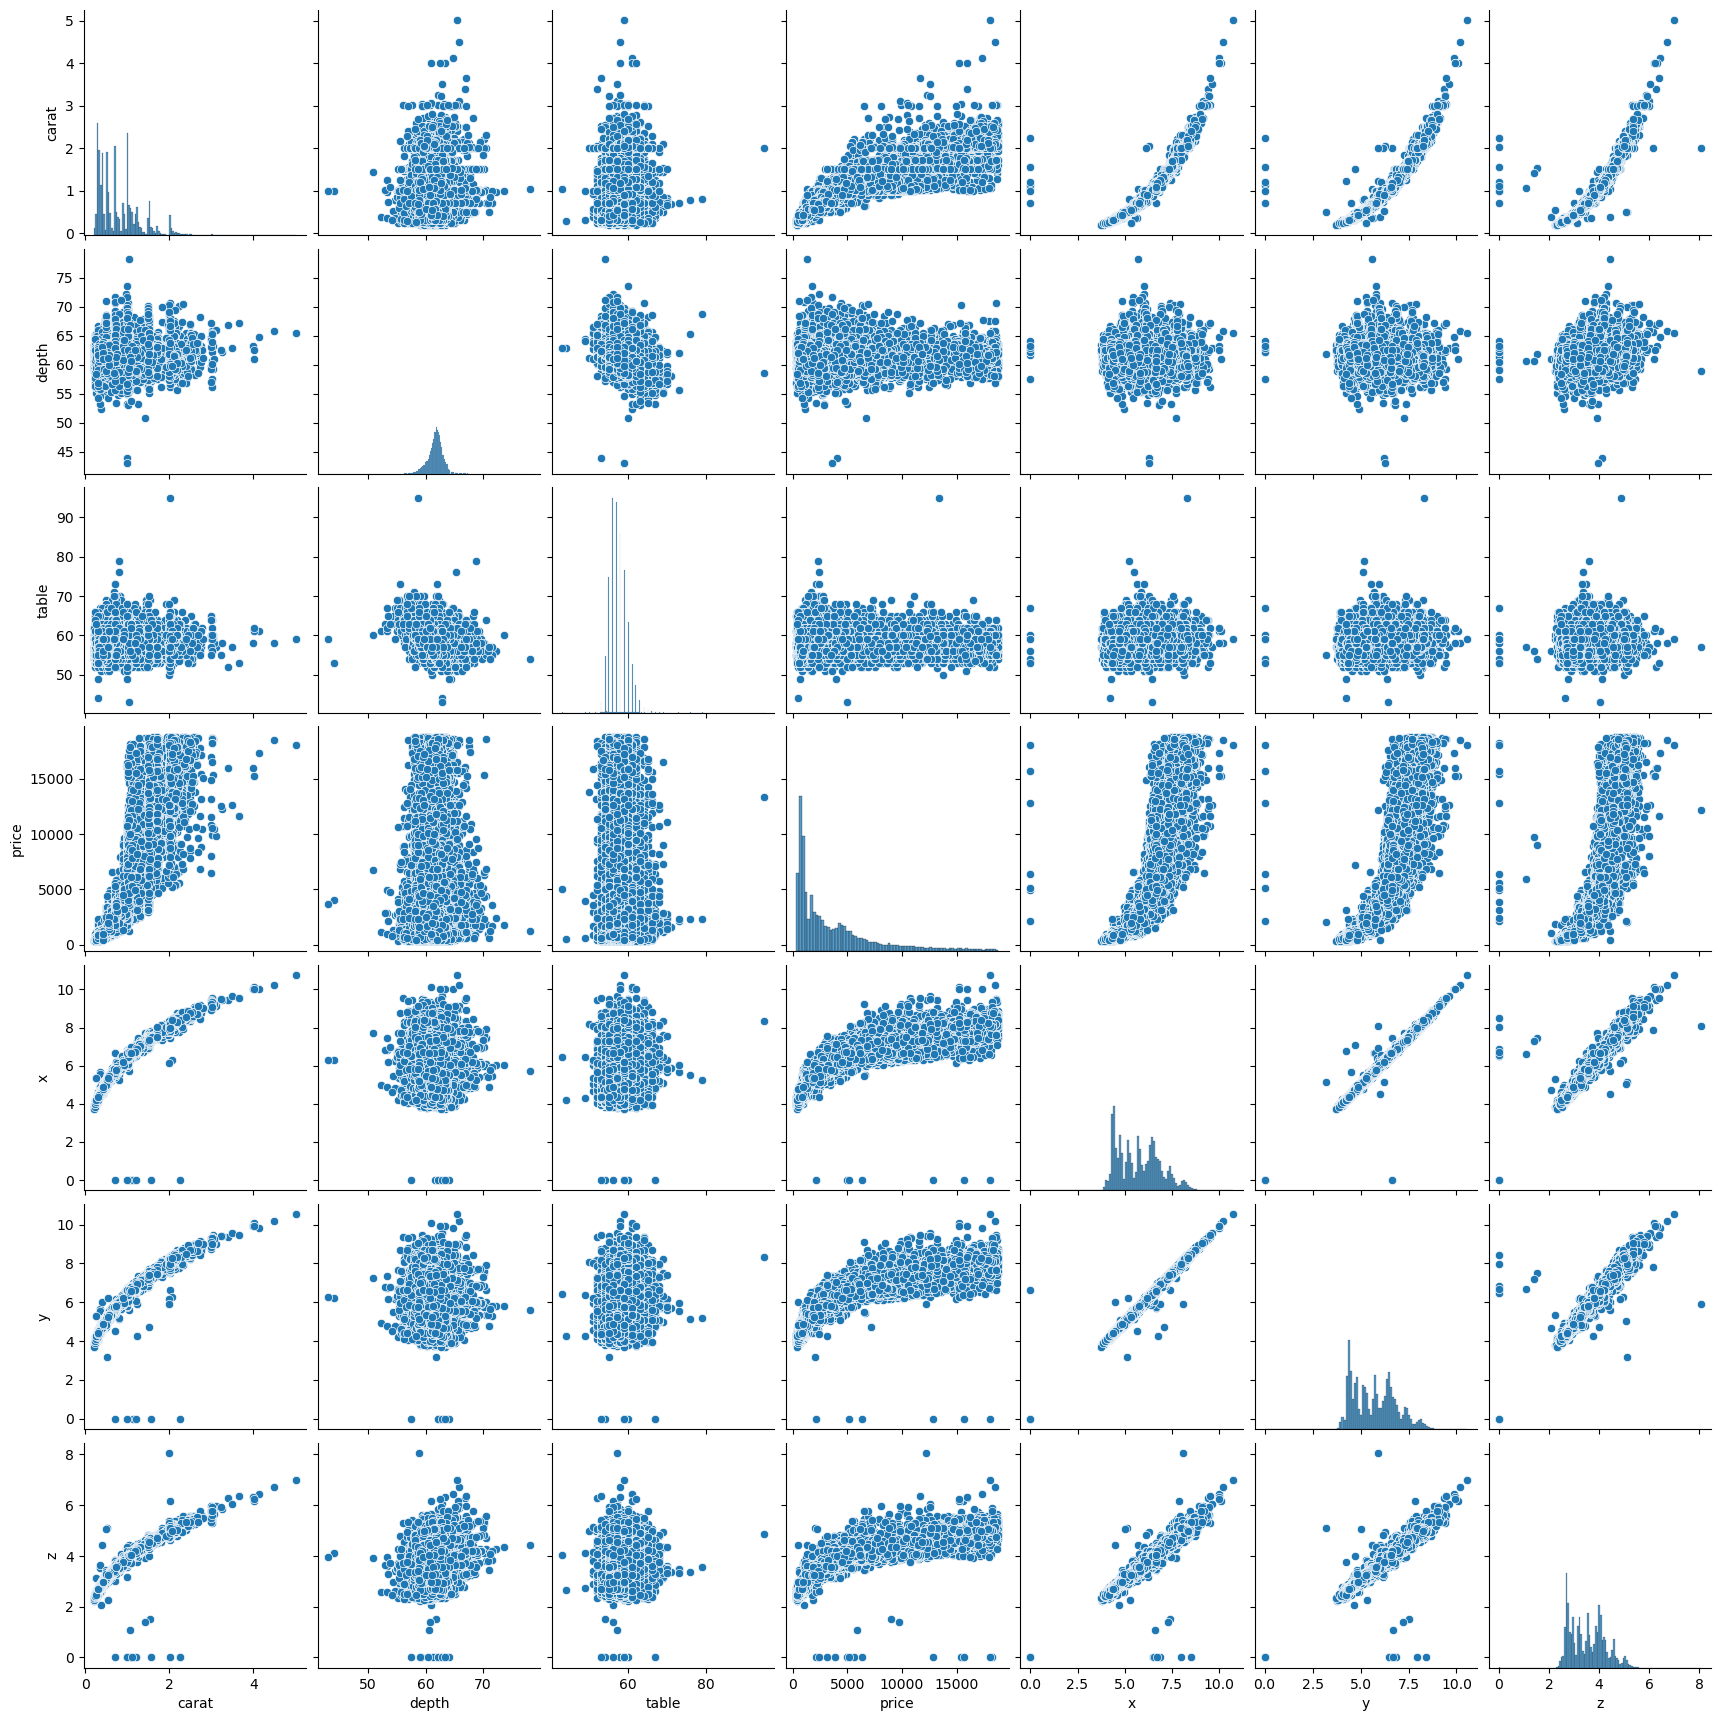

In [11]:
sns.pairplot(df)

In [12]:
df = df.drop(['depth', 'table'], axis = 1)
cat_features = ['cut','color']
axis_features = ['x','y','z']
num_features = ['carat']

X = df.drop(columns=['price'])
y = np.array(df.price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
axis_transformer = Pipeline(steps=[
    ('missing_num', KNNImputer(missing_values=0, n_neighbors=3, weights="uniform")),
    # ('kbin', KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal')),
    ('polynom', PolynomialFeatures(2,include_bias=False)),
    ('scaler', StandardScaler())])

num = Pipeline(steps=[
    ('missing_num', IterativeImputer(missing_values=0, max_iter=20)),
    # ('kbin', KBinsDiscretizer(n_bins=6, strategy='uniform', encode='ordinal')),
    # ('polynom', PolynomialFeatures(3,include_bias=False)),
    ('scaler', StandardScaler())
    ])


clarity_map = [{
    'col':'clarity',##### Обратить внимание
    'mapping':{'IF':8, 'VVS1':7, 'VVS2':6, 'VS1':5, 'VS2':4, 
               'SI1':3, 'SI2':2, 'I1':1}
    }]

clarity_transformer = Pipeline(steps=[
    ('missing_num', SimpleImputer(strategy = 'most_frequent')),
    ('ce',ce.OrdinalEncoder(mapping=clarity_map)),
    ('scaler', MinMaxScaler())
    ])    
    
CT = ColumnTransformer([
        ("axis_transformer", axis_transformer, axis_features),
        ("num", num, num_features),
        # убрать быстую разряженную 
        ("cat", OneHotEncoder(sparse_output=False), cat_features),
        ("ordinal_map", clarity_transformer, ['clarity'])##### Обратить внимание
        ]).set_output(transform='pandas')

display(CT)

ct = CT.fit_transform(X_train)
pd.DataFrame(ct).head().T

ColumnTransformer(transformers=[('axis_transformer',
                                 Pipeline(steps=[('missing_num',
                                                  KNNImputer(missing_values=0,
                                                             n_neighbors=3)),
                                                 ('polynom',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('scaler', StandardScaler())]),
                                 ['x', 'y', 'z']),
                                ('num',
                                 Pipeline(steps=[('missing_num',
                                                  IterativeImputer(max_iter=20,
                                                                   missing_values=0)),
                                                 ('scaler', StandardScaler())]),
                                 ['carat']),
                                ('cat', OneHotEncoder(sparse_output=False),
                                 ['cut', 'color']),
                                ('ordinal_map',
                                 Pipeline(steps=[('missing_num',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': IF      8
VVS1    7
VVS2    6
VS1     5
VS2     4
SI1     3
SI2     2
I1      1
dtype: int64}])),
                                                 ('scaler', MinMaxScaler())]),
                                 ['clarity'])])

,33911,20690,35823,3347,29421
axis_transformer__x,-0.010554,0.203016,0.567864,-0.250820,1.448840
axis_transformer__y,-0.039137,0.220889,0.525747,-0.227431,1.323758
axis_transformer__z,0.044047,0.231397,0.548450,-0.301829,1.456376
axis_transformer__x^2,-0.103908,0.104347,0.479914,-0.327964,1.489740
axis_transformer__x y,-0.117116,0.113780,0.458378,-0.317176,1.414142
axis_transformer__x z,-0.077207,0.119693,0.471884,-0.351379,1.499783
axis_transformer__y^2,-0.130520,0.122984,0.436239,-0.306226,1.338232
axis_transformer__y z,-0.090532,0.129211,0.450261,-0.340847,1.423823
axis_transformer__z^2,-0.051441,0.132581,0.458996,-0.373884,1.497999
num__carat,-0.206677,0.024173,0.359954,-0.416541,1.493216


In [14]:
model_pipe = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[  
                                ('preproc', CT),
                                ('estimator', SVR())
                            ]),
                        transformer=PowerTransformer(method="yeo-johnson"),
                        check_inverse = False)
                )])
model_pipe.fit(X_train, y_train)
y_pred = model_pipe.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(mse_irq(y_test, y_pred))

364594.7083283386
-1952260.0100594407


In [15]:
param_grid = [
    {'model__regressor__estimator':[SVR(kernel = 'rbf')],
     'model__regressor__estimator__C': [10, 20,  25, 30, 35],
     'model__regressor__estimator__gamma': [0.005, 0.05, 0.01, 0.1],
     # 'model__regressor__estimator__epsilon': [0.01, 0.1, 0.5, 1]
     
    }
]
cv = KFold(n_splits=5, shuffle=True)
scoring_mse_irq = make_scorer(mse_irq)
scoring_mse = make_scorer(mean_squared_error, greater_is_better=False)

scoring = {
    'MSE': scoring_mse,          # mean_squared_error
    'MSE_IRQ': scoring_mse_irq   # кастомная метрика
}

# grid_2 = GridSearchCV(model_pipe, n_jobs=-1, param_grid=param_grid, scoring=scoring, refit='MSE_IRQ', cv = cv)
grid_2 = RandomizedSearchCV(model_pipe, param_grid, cv=cv, n_jobs=-1, scoring=scoring_mse_irq)
grid_2.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('model',
                                              TransformedTargetRegressor(check_inverse=False,
                                                                         regressor=Pipeline(steps=[('preproc',
                                                                                                    ColumnTransformer(transformers=[('axis_transformer',
                                                                                                                                     Pipeline(steps=[('missing_num',
                                                                                                                                                      KNNImputer(missing_values=0,
                                                                                                                                                                 n_neighbors=3)),
                                                                                                                                                     ('polynom',
                                                                                                                                                      PolynomialFeatures(inc...
dtype: int64}])),
                                                                                                                                                     ('scaler',
                                                                                                                                                      MinMaxScaler())]),
                                                                                                                                     ['clarity'])])),
                                                                                                   ('estimator',
                                                                                                    SVR())]),
                                                                         transformer=PowerTransformer()))]),
                   n_jobs=-1,
                   param_distributions=[{'model__regressor__estimator': [SVR()],
                                         'model__regressor__estimator__C': [10,
                                                                            20,
                                                                            25,
                                                                            30,
                                                                            35],
                                         'model__regressor__estimator__gamma': [0.005,
                                                                                0.05,
                                                                                0.01,
                                                                                0.1]}],
                   scoring=make_scorer(mse_irq, response_method='predict'))

In [16]:
grid_result = pd.DataFrame(grid_2.cv_results_).T
grid_result

,0,1,2,3,4,5,6,7,8,9
mean_fit_time,77.694558,45.881695,45.529222,40.465142,49.47214,82.598604,40.654121,48.584238,45.261864,54.481578
std_fit_time,2.23768,1.205746,1.384711,1.423831,2.619835,6.186738,2.117248,5.043735,1.813699,9.157105
mean_score_time,8.041884,8.941544,9.969734,10.959262,9.328107,8.027002,8.457272,9.715682,7.889588,4.064734
std_score_time,0.294812,0.238117,0.702079,1.023798,0.406313,0.97335,0.604098,1.992591,0.450165,0.500477
param_model__regressor__estimator__gamma,0.05,0.01,0.005,0.005,0.01,0.1,0.01,0.05,0.1,0.1
param_model__regressor__estimator__C,30,20,35,25,35,30,30,10,10,25
param_model__regressor__estimator,SVR(),SVR(),SVR(),SVR(),SVR(),SVR(),SVR(),SVR(),SVR(),SVR()
params,"{'model__regressor__estimator__gamma': 0.05, '...","{'model__regressor__estimator__gamma': 0.01, '...","{'model__regressor__estimator__gamma': 0.005, ...","{'model__regressor__estimator__gamma': 0.005, ...","{'model__regressor__estimator__gamma': 0.01, '...","{'model__regressor__estimator__gamma': 0.1, 'm...","{'model__regressor__estimator__gamma': 0.01, '...","{'model__regressor__estimator__gamma': 0.05, '...","{'model__regressor__estimator__gamma': 0.1, 'm...","{'model__regressor__estimator__gamma': 0.1, 'm..."
split0_test_score,-2211774.375785,-2382929.194688,-2650660.965044,-2705254.405946,-2457885.980157,-2129674.229072,-2440592.645573,-2221100.078551,-2100489.306947,-2084763.714725
split1_test_score,-2124902.880232,-2218760.889122,-2383424.374199,-2498563.006997,-2178595.263555,-2198815.352364,-2184695.227405,-2083977.952617,-2041414.358037,-2146406.067529


In [17]:
final = grid_2.best_estimator_
final.fit(X_train, y_train)
y_pred_fin = final.predict(X_test)
print(mean_squared_error(y_test, y_pred_fin))
print(mse_irq(y_test, y_pred_fin))

343564.75015069335
-1851770.4247358


In [18]:
model_svr = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[  
                                ('preproc', CT),
                                ('estimator', SVR(C = 35, gamma = 0.1))
                            ]),
                        transformer=PowerTransformer(method="yeo-johnson"),
                        check_inverse = False)
                )])
model_svr.fit(X_train, y_train)

Pipeline(steps=[('model',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(steps=[('preproc',
                                                                       ColumnTransformer(transformers=[('axis_transformer',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         KNNImputer(missing_values=0,
                                                                                                                                    n_neighbors=3)),
                                                                                                                        ('polynom',
                                                                                                                         PolynomialFeatures(include_bias=False)),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['x',
                                                                                                         'y',
                                                                                                         'z']),
                                                                                                       ('num',
                                                                                                        Pipeline(st...
                                                                                                        OneHotEncoder(sparse_output=False),
                                                                                                        ['cut',
                                                                                                         'color']),
                                                                                                       ('ordinal_map',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                                                        ('ce',
                                                                                                                         OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': IF      8
VVS1    7
VVS2    6
VS1     5
VS2     4
SI1     3
SI2     2
I1      1
dtype: int64}])),
                                                                                                                        ('scaler',
                                                                                                                         MinMaxScaler())]),
                                                                                                        ['clarity'])])),
                                                                      ('estimator',
                                                                       SVR(C=35,
                                                                           gamm

In [19]:
param_grid = [
    {'model__regressor__estimator':[SVR(C = 35, gamma = 0.1)],
     'model__regressor__preproc__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
     'model__regressor__preproc__ordinal_map__ce':[ce.OrdinalEncoder(mapping=clarity_map), TargetEncoder()], 
     'model__regressor__preproc__axis_transformer__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
     'model__transformer':[PowerTransformer(),QuantileTransformer(n_quantiles=1000, output_distribution="uniform")]
    }
]
cv = KFold(n_splits=5, shuffle=True)
scoring_mse_irq = make_scorer(mse_irq)
scoring_mse = make_scorer(mean_squared_error, greater_is_better=False)

scoring = {
    'MSE': scoring_mse,          # mean_squared_error
    'MSE_IRQ': scoring_mse_irq   # кастомная метрика
}

grid = GridSearchCV(model_svr, param_grid, cv=cv, n_jobs=-1, scoring=scoring, refit='MSE_IRQ')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        TransformedTargetRegressor(check_inverse=False,
                                                                   regressor=Pipeline(steps=[('preproc',
                                                                                              ColumnTransformer(transformers=[('axis_transformer',
                                                                                                                               Pipeline(steps=[('missing_num',
                                                                                                                                                KNNImputer(missing_values=0,
                                                                                                                                                           n_neighbors=3)),
                                                                                                                                               ('polynom',
                                                                                                                                                PolynomialFeatures(include_b...
                          'model__regressor__preproc__ordinal_map__ce': [OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                  'data_type': dtype('O'),
                                                                                                  'mapping': IF      8
VVS1    7
VVS2    6
VS1     5
VS2     4
SI1     3
SI2     2
I1      1
dtype: int64}]),
                                                                         TargetEncoder()],
                          'model__transformer': [PowerTransformer(),
                                                 QuantileTransformer()]}],
             refit='MSE_IRQ',
             scoring={'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'MSE_IRQ': make_scorer(mse_irq, response_method='predict')})

In [20]:
results = pd.DataFrame(grid.cv_results_).T
results

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
mean_fit_time,95.861211,3.346137,108.682765,8.216524,85.2333,1.935328,100.926936,6.420024,95.879875,1.819319,...,76.255544,5.521729,60.306842,2.509874,62.360573,4.891725,53.776829,2.157512,46.948697,4.246539
std_fit_time,10.856668,0.610271,7.953207,1.234081,1.773511,0.165966,14.478495,0.874845,13.030942,0.107645,...,7.631715,0.809113,5.78875,0.291434,8.169716,0.59478,6.109063,0.184938,5.690274,0.415571
mean_score_time,6.719271,0.47007,10.491621,0.720341,7.139016,0.339325,9.39224,0.678958,7.710967,0.286734,...,11.326729,0.684696,10.401285,0.331668,11.42461,0.719069,10.195389,0.313929,7.248444,0.677122
std_score_time,0.597212,0.130561,1.499339,0.17198,0.696782,0.050153,0.822367,0.081038,0.875711,0.012494,...,1.452536,0.09459,2.422259,0.02548,2.553971,0.05583,1.088258,0.011723,1.632747,0.106949
param_model__regressor__estimator,"SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)",...,"SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)","SVR(C=35, gamma=0.1)"
param_model__regressor__preproc__axis_transformer__scaler,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),...,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()
param_model__regressor__preproc__num__scaler,StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),MinMaxScaler(),...,StandardScaler(),StandardScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()
param_model__regressor__preproc__ordinal_map__ce,"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder(),"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder(),"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",...,TargetEncoder(),TargetEncoder(),"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder(),"OrdinalEncoder(mapping=[{'col': 'clarity', 'da...","OrdinalEncoder(mapping=[{'col': 'clarity', 'da...",TargetEncoder(),TargetEncoder()
param_model__transformer,PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),...,PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer(),PowerTransformer(),QuantileTransformer()
params,"{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...",...,"{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35, gamm...","{'model__regressor__estimator': SVR(C=35,

In [21]:
final_end = grid.best_estimator_
final_end.fit(X_train, y_train)
y_pred_fin = final_end.predict(X_test)
print(mean_squared_error(y_test, y_pred_fin))
print(mse_irq(y_test, y_pred_fin))

353049.3427081627
-1877593.1630783833


In [26]:
model = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Ridge())
                            ]),
                        transformer=PowerTransformer(method="box-cox"),
                        check_inverse = False)
                )])
model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(steps=[('preproc',
                                                                       ColumnTransformer(transformers=[('axis_transformer',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         KNNImputer(missing_values=0,
                                                                                                                                    n_neighbors=3)),
                                                                                                                        ('polynom',
                                                                                                                         PolynomialFeatures(include_bias=False)),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['x',
                                                                                                         'y',
                                                                                                         'z']),
                                                                                                       ('num',
                                                                                                        Pipeline(st...
                                                                                                        ['cut',
                                                                                                         'color']),
                                                                                                       ('ordinal_map',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                                                        ('ce',
                                                                                                                         OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': IF      8
VVS1    7
VVS2    6
VS1     5
VS2     4
SI1     3
SI2     2
I1      1
dtype: int64}])),
                                                                                                                        ('scaler',
                                                                                                                         MinMaxScaler())]),
                                                                                                        ['clarity'])])),
                                                                      ('estimator',
                                                                       Ridge())]),
                                            transformer=PowerTransformer(method='box-cox')))])

In [27]:
y_pred= model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(mse_irq(y_test, y_pred))

631265.5166333838
-3370078.464645971


In [28]:
model = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', Lars())
                            ]),
                        transformer=PowerTransformer(method="box-cox"),
                        check_inverse = False)
                )])
model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(steps=[('preproc',
                                                                       ColumnTransformer(transformers=[('axis_transformer',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         KNNImputer(missing_values=0,
                                                                                                                                    n_neighbors=3)),
                                                                                                                        ('polynom',
                                                                                                                         PolynomialFeatures(include_bias=False)),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['x',
                                                                                                         'y',
                                                                                                         'z']),
                                                                                                       ('num',
                                                                                                        Pipeline(st...
                                                                                                        OneHotEncoder(sparse_output=False),
                                                                                                        ['cut',
                                                                                                         'color']),
                                                                                                       ('ordinal_map',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                                                        ('ce',
                                                                                                                         OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': IF      8
VVS1    7
VVS2    6
VS1     5
VS2     4
SI1     3
SI2     2
I1      1
dtype: int64}])),
                                                                                                                        ('scaler',
                                                                                                                         MinMaxScaler())]),
                                                                                                        ['clarity'])])),
                                                                      ('estimator',
                                                                       Lars())]),
                                            transformer=PowerTransformer(metho

In [30]:
y_pred= model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(mse_irq(y_test, y_pred))

7.48153215910652e+22
-4.846592544139914e+23


In [31]:
model = Pipeline([
                ('model', TransformedTargetRegressor(
                        regressor = Pipeline(steps=[
                                ('preproc', CT),
                                ('estimator', KNeighborsRegressor())
                            ]),
                        transformer=PowerTransformer(method="box-cox"),
                        check_inverse = False)
                )])
model.fit(X_train, y_train)

Pipeline(steps=[('model',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(steps=[('preproc',
                                                                       ColumnTransformer(transformers=[('axis_transformer',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         KNNImputer(missing_values=0,
                                                                                                                                    n_neighbors=3)),
                                                                                                                        ('polynom',
                                                                                                                         PolynomialFeatures(include_bias=False)),
                                                                                                                        ('scaler',
                                                                                                                         StandardScaler())]),
                                                                                                        ['x',
                                                                                                         'y',
                                                                                                         'z']),
                                                                                                       ('num',
                                                                                                        Pipeline(st...
                                                                                                         'color']),
                                                                                                       ('ordinal_map',
                                                                                                        Pipeline(steps=[('missing_num',
                                                                                                                         SimpleImputer(strategy='most_frequent')),
                                                                                                                        ('ce',
                                                                                                                         OrdinalEncoder(mapping=[{'col': 'clarity',
                                                                                                                                                  'data_type': dtype('O'),
                                                                                                                                                  'mapping': IF      8
VVS1    7
VVS2    6
VS1     5
VS2     4
SI1     3
SI2     2
I1      1
dtype: int64}])),
                                                                                                                        ('scaler',
                                                                                                                         MinMaxScaler())]),
                                                                                                        ['clarity'])])),
                                                                      ('estimator',
                                                                       KNeighborsRegressor())]),
                                            transformer=PowerTransformer(method='box-cox')))])

In [32]:
y_pred= model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(mse_irq(y_test, y_pred))

548110.723403942
-2782679.684042272
